In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

# ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = tables.table_id.str.contains('acs') & tables.row_count.between(190000, 220000)
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
57,acs_blockgroup_pop_2014,216367
56,acs_blockgroup_2014,216367
55,acs_blockgroup2_2014,216367
51,acs_blockgroup_2016,216362
53,acs_blockgroup_pop_2016,216362
52,acs_blockgroup_pop_2015,216362
48,acs_blockgroup2_2015,216362
49,acs_blockgroup2_2016,216362
50,acs_blockgroup_2015,216362
34,acs_with_geo_2014,216330


# census_block, left join fcc and acs attributes

In [204]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , block.total_length 
    , block.land_area
    , block.elevation_mean
    , block.elevation_range
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , fcc_demography.population_2016
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , SUM(total_length) AS road_length
    , SUM(land_area) AS land_area
    , AVG(elevation_mean) AS avg_elevation
    , AVG(elevation_range) AS avg_elevation_range
  FROM block_level
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.int_avail_per
  , SAFE_DIVIDE(block_group_level.road_length, block_group_level.land_area) AS road_length_per_area
  , block_group_level.avg_elevation
  , block_group_level.avg_elevation_range
  , SAFE_DIVIDE(acs_blockgroup_2016.race_total, block_group_level.road_length) AS population_per_area
  , acs_blockgroup_2016.median_household_income_in_the_past_12_months AS median_income
  , SAFE_DIVIDE(acs_housing_unit.estimate_total, block_group_level.land_area) AS housing_units_per_area
  , acs_education_average.avg_years_of_edu
  , acs_employment_percentage.unemployment_rate
  , acs_gender_age.avg_age
  --, acs_gender_age.male_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.white, acs_blockgroup_2016.race_total) AS white_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.black_or_african_american, acs_blockgroup_2016.race_total) AS black_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.asian, acs_blockgroup_2016.race_total) AS asian_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.american_indian_and_alaska_native, acs_blockgroup_2016.race_total) AS native_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.hispanic_or_latino, acs_blockgroup_2016.ethnicity_total) AS hispanic_ratio
FROM block_group_level
LEFT JOIN broadband.acs_blockgroup_2016
  ON block_group_level.block_group = acs_blockgroup_2016.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.acs_hispanic
  ON block_group_level.block_group = acs_hispanic.block_group_code
"""

data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [205]:
data.shape

(215566, 10)

### Missing values

In [206]:
data.count() / data.shape[0] * 100

int_avail_per             100.000000
road_length_per_area       99.997681
avg_elevation             100.000000
avg_elevation_range       100.000000
population_per_area        99.959641
median_income              99.968455
housing_units_per_area     92.112392
avg_years_of_edu           96.274459
unemployment_rate          93.894213
avg_age                    92.077600
dtype: float64

Text(0.5,0,'Internet availability percentage')

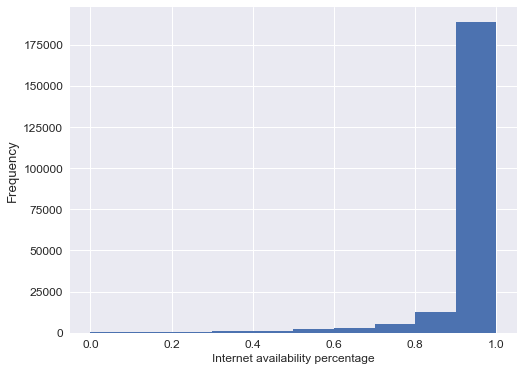

In [207]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [209]:
data.int_avail_per.describe()

count    215566.000000
mean          0.958990
std           0.114091
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per, dtype: float64

In [210]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', 100 - full_coverage)
print('block_group without full coverage', full_coverage)

block_group with full coverage 24.538192479333475
block_group without full coverage 75.46180752066653


# Correlation Analysis

Removing ethnicity & NA

In [211]:
existing_data = data.dropna()
existing_data.describe()

,int_avail_per,road_length_per_area,avg_elevation,avg_elevation_range,population_per_area,housing_units_per_area,avg_years_of_edu,unemployment_rate,avg_age
count,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000
mean,0.960428,0.014816,256.707139,10.316462,0.137309,0.000080,13.184850,0.095137,38.585959
std,0.112695,0.010942,354.348821,18.775304,0.920002,0.000196,1.452707,0.114988,6.618031
min,0.000000,0.000054,-59.989834,0.000000,0.000042,0.000000,3.937500,0.000000,15.810897
25%,1.000000,0.005271,45.526638,1.500000,0.030731,0.000006,12.345315,0.032389,34.364090
50%,1.000000,0.012957,183.416035,4.205882,0.075097,0.000035,13.133903,0.066826,38.263711
75%,1.000000,0.021732,284.005328,11.000000,0.135970,0.000082,14.073802,0.120994,42.222753
max,1.000000,0.191426,3260.102705,720.090909,318.793390,0.044057,26.000000,10.875000,90.769231


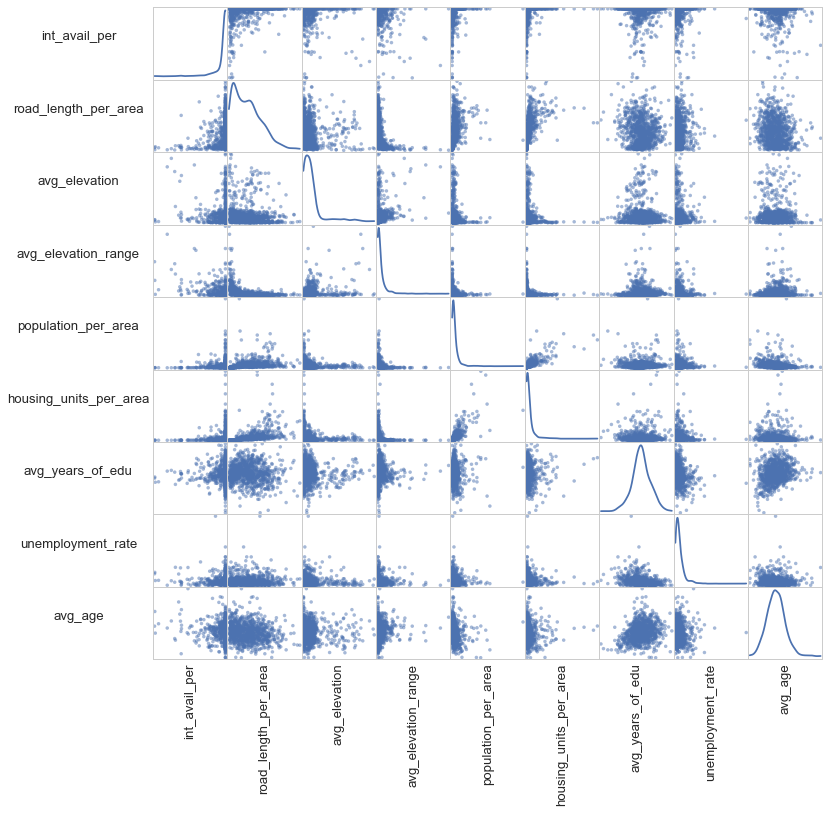

In [212]:
from pandas.plotting import scatter_matrix

sns.set_style('whitegrid')
sm = scatter_matrix(existing_data.sample(1000), figsize=(12, 12), diagonal='kde')

for s in sm.reshape(-1):
    #Change label rotation
    s.xaxis.label.set_rotation(90)
    s.yaxis.label.set_rotation(0)
    
    # offset label when rotating to prevent overlap of figure
    s.get_yaxis().set_label_coords(-1.0, 0.5)
    
    # Hide all ticks
    s.set_xticks(())
    s.set_yticks(())

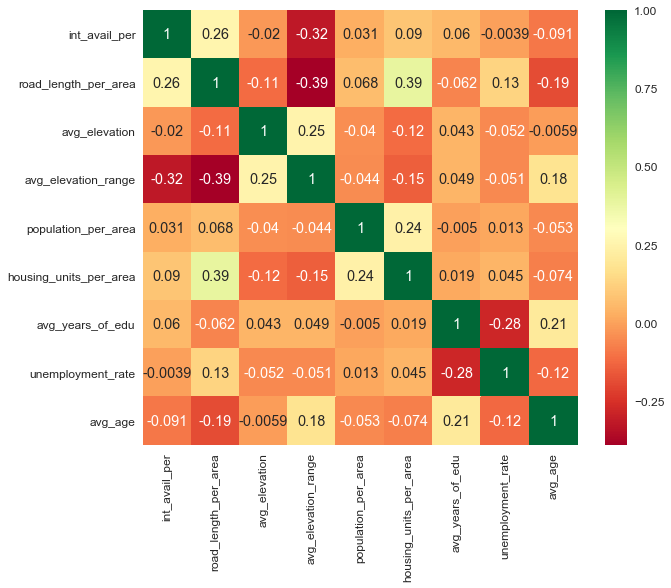

In [214]:
corr = existing_data.corr()

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax, cmap='RdYlGn', square=True, annot=True)

# Model

In [226]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X = existing_data.drop(columns='int_avail_per')
y = existing_data['int_avail_per']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_estimators=100)

params = {
    'n_estimators': [200, 500, 1000],
    'min_samples_split': [5, 15, 20],
    'max_depth': [50, 100],
}

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

print('Train score', grid_search.score(X_train, y_train))
print('Test score', grid_search.score(X_test, y_test))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 170.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 339.6min finished


Train score 0.6826611701382266
Test score 0.311246114197985


In [230]:
grid_search.best_params_

{'max_depth': 150, 'min_samples_split': 20, 'n_estimators': 1000}

In [229]:
coefficients = pd.DataFrame(list(zip(X.columns, grid_search.best_estimator_.feature_importances_))
                            , columns=['feature', 'coef'])
coefficients.sort_values('coef', ascending=False)

,feature,coef
3,population_per_area,0.375294
1,avg_elevation,0.127039
2,avg_elevation_range,0.124021
0,road_length_per_area,0.082915
8,avg_age,0.070978
6,avg_years_of_edu,0.068982
4,median_income,0.065721
7,unemployment_rate,0.055230
5,housing_units_per_area,0.029821
